In [1]:
#required libraries and settings
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import io
import math

import BMILorenz

In [2]:
#settings

J = 40 #dimension of Lorenz Model
observationSigma = 0.01 #standard deviation of the observations


In [3]:
#initialize the model
J = 40 #dimension of Lorenz Model

#make a starting state vector
commonStartState = np.zeros(J)
commonStartState[19]=0.01

# Define settings data
settings = {'J': J,
            'F': 8.0,
            'startTime': 0.0,
            'endTime': 20.0,
            'dt':1e-3,
            'startState': commonStartState}

# Write YAML file
with io.open('settings.yaml', 'w', encoding='utf8') as outfile:
    yaml.dump(settings, outfile, default_flow_style=False, allow_unicode=True)

In [4]:
N = 25 #numeber of ensemble members

p = 0.80
#start with  an empty ensemble
ensemble = []


#create and initialize an instance of the BMILorenz class
truthModel = BMILorenz.BMILorenz ()
truthModel.initialize('settings.yaml')

output = pd.DataFrame(columns = ['truth','observation'])

for n in range (N):
    #add an ensemble methods
    ensemble.append(BMILorenz.BMILorenz ())
    ensemble[n].initialize('settings.yaml')
    ensemble[n].set_value_at_indices('state',5,ensemble[n].get_value_at_indices('state',5) + np.random.randn(1)*0.01)
    
    #also add a column to the output dataframe to store the output
    output['ensemble' + str(n)]= np.nan
    
 

In [5]:
def H(state):
    return state

def EnKF(ensembleForecast, observationEnsemble, transformation):
    #use notation from Evenson 2003.
    A=ensembleForecast
    D=observationEnsemble
    H=transformation
    N=np.shape(A)[1]

    Apr = A @ (np.eye(N)-(1/N)*np.ones(N))
    Dpr = D - H(A)
    gamma=D @ (np.eye(N)-(1/N)*np.ones(N))


    #now calculate [U,S,V]=SVD(H*Apr+gamma)
    Utemp,Sigma,vH = np.linalg.svd(H(Apr)+gamma)
    #only keep p % of singular values, discard minimum of 1.
    pN = max(1, math.floor(N * (1-p)))

    U=np.zeros([np.shape(D)[0],N])

    U[0:(np.shape(Utemp)[0]),0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]=Utemp[:,0:min((np.shape(Utemp)[1]-pN-1),np.shape(U)[1]-pN-1)]

    Sigma=np.diag(Sigma) @ np.diag(Sigma).T
    Sigma = np.power(np.diag(Sigma),-1)
    Sigma[-pN:] = 0
    LambdaInv = np.zeros([N,N])
    LambdaInv[0:np.shape(Sigma)[0],0:np.shape(Sigma)[0]]=np.diag(Sigma)

    X1=LambdaInv @ U.T
    X2=X1 @ Dpr
    X3=U @ X2
    X4=H(Apr).T @ X3
    ensembleAnalyses = A + Apr @ X4
    return ensembleAnalyses

In [6]:
#spin up the Ensemble. 

while truthModel.get_current_time()< 3.0:
    
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',5)
    
    observation = truthModel.get_value('state') + observationSigma * np.random.randn(J)
    output.at[truthModel.get_current_time(),'observation'] = observation[5]
    
    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',5)
        
    #TODO update observation on bases of observation
    
    #TODO track statistics metrics


In [7]:
#run 

foreCastEnsemble = np.zeros([J,N])
observationEnsemble = np.zeros([J,N])
updateTime = 4.0
updateInterval = 1.0

while truthModel.get_current_time()<truthModel.get_end_time():
#for n in range (1):
    truthModel.update()
    output.loc[truthModel.get_current_time(),'truth'] = truthModel.get_value_at_indices('state',5)
    
    observation = truthModel.get_value('state') + observationSigma * np.random.randn(J)
    output.at[truthModel.get_current_time(),'observation'] = observation[5]
    
    

    #loop through the ensemble members and store the state after each update
    for n in range (N):
        ensemble[n].update()
        foreCastEnsemble[:,n] = ensemble[n].get_value('state')
        observationEnsemble[:,n] = observation + np.random.randn(J)
        output.at[ensemble[n].get_current_time(),'ensemble' + str(n)] = ensemble[n].get_value_at_indices('state',5)
        
    #TODO update ensemble on bases of observation
    if truthModel.get_current_time() > updateTime:
        updateTime = updateTime + updateInterval
        analysesEnsemble = EnKF(foreCastEnsemble,observationEnsemble,H)
        np.clip(analysesEnsemble, -10, 20, out=analysesEnsemble)

        for n in range (N):
            ensemble[n].set_value('state',analysesEnsemble[:,n])
    
    
    #TODO track statistics metrics


In [8]:
np.amax(analysesEnsemble)

10.537047142636958

In [9]:
truthModel.get_current_time()

20.00000000000146

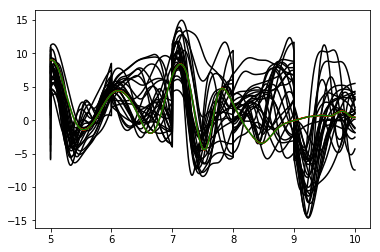

In [11]:
plt.plot(output.loc[5:10,'ensemble0':],'k')
plt.plot(output.loc[5:10,'observation'],'r')
plt.plot(output.loc[5:10,'truth'],'g')

plt.show()

In [12]:
np.shape(foreCastEnsemble)[1]

25

In [16]:
N=25
np.shape(foreCastEnsemble @ (np.eye(N)-(1/N)*np.ones(N)))

(40, 25)